# Comparing Ecker Data with Anode Chemistry

Improved diffusion coefficient formulae for spherical and coin models

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
os.chdir(pybamm.__path__[0]+'/..')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
You should consider upgrading via the '/home/katiez/FUSE/pybamm/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Import Ecker Data

In [2]:
voltage_data_1C = pd.read_csv("pybamm/input/discharge_data/Ecker_1C.csv", header=None).to_numpy()
voltage_data_5C = pd.read_csv("pybamm/input/discharge_data/Ecker_5C.csv", header=None).to_numpy()

Choose spherical models

In [3]:
# choose DFN
model1 = pybamm.lithium_ion. DFN()
# choose SPMe
model2 = pybamm.lithium_ion. SPMe()

Set chemistry to version 2

In [4]:
chemistry_new = pybamm.parameter_sets.Ecker2015_v2

## Spherical

Import parameter sets: s denotes spherical

0s - original PyBaMM function for spherical model

1s - piecewise spherical function for spherical model

2s - piecewise coin function for spherical model

In [5]:
# original PyBaMM function
parameter_values0s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values0s.update({"Current function [A]": "[input]"})
parameter_values0s.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_original"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [6]:
# piecewise spherical function
parameter_values1s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values1s.update({"Current function [A]": "[input]"})

In [7]:
# piecewise coin function
parameter_values2s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values2s.update({"Current function [A]": "[input]"})
parameter_values2s.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_piecewise_coin"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

Choose mesh

In [8]:
var = pybamm.standard_spatial_vars
var_pts_n1 = {
    var.x_n: int(parameter_values0s.evaluate(model2.param.L_n / 1e-6)),
    var.x_s: int(parameter_values0s.evaluate(model2.param.L_s / 1e-6)),
    var.x_p: int(parameter_values0s.evaluate(model2.param.L_p / 1e-6)),
    var.r_n: int(parameter_values0s.evaluate(model2.param.R_n / 1e-7)),
    var.r_p: int(parameter_values0s.evaluate(model2.param.R_p / 1e-7)),
}

Build simulations (SPMe)

S0 - original PyBaMM function for spherical model

S1 - piecewise spherical function for spherical model

S2 - piecewise coin function for spherical model

For DFN, change model2 to model1

In [9]:
sim_S0 = pybamm.Simulation(model2, parameter_values=parameter_values0s, var_pts=var_pts_n1)
sim_S1 = pybamm.Simulation(model2, parameter_values=parameter_values1s, var_pts=var_pts_n1)
sim_S2 = pybamm.Simulation(model2, parameter_values=parameter_values2s, var_pts=var_pts_n1)

Solve simulations for 1C and 5C

In [10]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values0s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_S0 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_S0.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_S0[i] = sim_S0.solution

In [11]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values1s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_S1 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_S1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_S1[i] = sim_S1.solution

In [13]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values2s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_S2 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_S2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_S2[i] = sim_S2.solution

Plot spherical results

2020-09-18 15:07:12,156 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


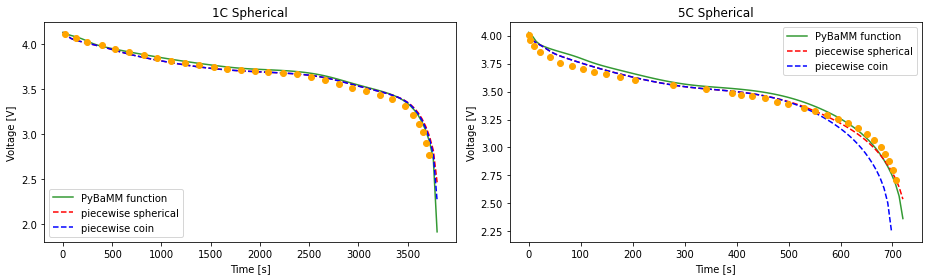

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_S0 = solutions_S0[0]["Time [s]"].entries
t_sol_S1 = solutions_S1[0]["Time [s]"].entries
t_sol_S2 = solutions_S2[0]["Time [s]"].entries
ax1.plot(t_sol_S0, solutions_S0[0]["Terminal voltage [V]"](t_sol_S0), label="PyBaMM function", alpha=0.8, color="green")
ax1.plot(t_sol_S1, solutions_S1[0]["Terminal voltage [V]"](t_sol_S1), label="piecewise spherical", linestyle="--", color="red")
ax1.plot(t_sol_S2, solutions_S2[0]["Terminal voltage [V]"](t_sol_S2), label="piecewise coin", linestyle="--", color="blue")
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o", color='orange')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Spherical")
ax1.legend(loc="best")

# plot the 5C Spherical results
t_sol_S0 = solutions_S0[1]["Time [s]"].entries
t_sol_S1 = solutions_S1[1]["Time [s]"].entries
t_sol_S2 = solutions_S2[1]["Time [s]"].entries
ax2.plot(t_sol_S0, solutions_S0[1]["Terminal voltage [V]"](t_sol_S0), label="PyBaMM function", alpha=0.8, color="green")
ax2.plot(t_sol_S1, solutions_S1[1]["Terminal voltage [V]"](t_sol_S1), label="piecewise spherical",linestyle="--", color="red")
ax2.plot(t_sol_S2, solutions_S2[1]["Terminal voltage [V]"](t_sol_S2), label="piecewise coin", linestyle="--", color="blue")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o", color='orange')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Spherical")
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('adjust fit4 exponential spherical')
plt.show()

## Plotting New Chemistry with Coin Geometry (SPMe Only)

Set particle shape to negative coin (default particle shape is spherical)

In [15]:
coin = {"particle shape":"negative coin"}

Build models for coin model

options = coin sets particle shape to negative coin

In [16]:
# choose DFN
var = pybamm.standard_spatial_vars
model3 = pybamm.lithium_ion. DFN(build=False, options=coin)
# add rho_n
model3.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model3.param.R_n,
    }
)
# delete r_n
model3.variables.pop('r_n', None)
model3.variables.pop('r_n [m]', None)
model3.build_model()

In [17]:
# choose SPMe
var = pybamm.standard_spatial_vars
model4 = pybamm.lithium_ion. SPMe(build=False, options=coin)
# add rho_n
model4.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model3.param.R_n,
    }
)
# delete r_n
model4.variables.pop('r_n', None)
model4.variables.pop('r_n [m]', None)
model4.build_model()

Import parameter sets: c denotes coin

0c - original PyBaMM function for coin model

1c - piecewise spherical function for coin model

2c - piecewise coin function for coin model

In [18]:
# original PyBaMM function
parameter_values0c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values0c.update({"Current function [A]": "[input]"})
parameter_values0c.update({"Negative particle radius [m]": 4.5e-05})
parameter_values0c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin_original"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [19]:
# piecewise spherical function
parameter_values1c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values1c.update({"Current function [A]": "[input]"})
parameter_values1c.update({"Negative particle radius [m]": 2.1e-05})
parameter_values1c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin_piecewise_spherical"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [20]:
# piecewise coin function
parameter_values2c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values2c.update({"Current function [A]": "[input]"})
parameter_values2c.update({"Negative particle radius [m]": 2.1e-05})
parameter_values2c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

Choose mesh

In [21]:
var = pybamm.standard_spatial_vars
var_pts_n2 = {
    var.x_n: int(parameter_values0c.evaluate(model4.param.L_n / 1e-6)),
    var.x_s: int(parameter_values0c.evaluate(model4.param.L_s / 1e-6)),
    var.x_p: int(parameter_values0c.evaluate(model4.param.L_p / 1e-6)),
    var.rho_n: int(parameter_values0c.evaluate(model4.param.R_n / 1e-7)),
    var.r_p: int(parameter_values0c.evaluate(model4.param.R_p / 1e-7)),
}

Build simulations (SPMe)

C0 - original PyBaMM function for coin model

C1 - piecewise spherical function for coin model

C2 - piecewise coin function for coin model

For DFN, change model4 to model3

In [22]:
sim_C0 = pybamm.Simulation(model4, parameter_values=parameter_values0c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))
sim_C1 = pybamm.Simulation(model4, parameter_values=parameter_values1c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))
sim_C2 = pybamm.Simulation(model4, parameter_values=parameter_values2c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))

Solve simulations for 1C and 5C

In [23]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values0c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_C0 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_C0.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_C0[i] = sim_C0.solution

In [24]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values1c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_C1 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_C1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_C1[i] = sim_C1.solution

In [25]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values2c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_C2 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_C2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_C2[i] = sim_C2.solution

Plot coin results

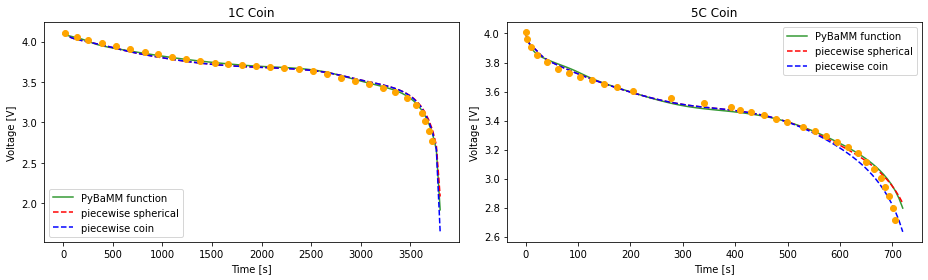

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_C0 = solutions_C0[0]["Time [s]"].entries
t_sol_C1 = solutions_C1[0]["Time [s]"].entries
t_sol_C2 = solutions_C2[0]["Time [s]"].entries
ax1.plot(t_sol_C0, solutions_C0[0]["Terminal voltage [V]"](t_sol_C0), label="PyBaMM function", alpha=0.8, color="green")
ax1.plot(t_sol_C1, solutions_C1[0]["Terminal voltage [V]"](t_sol_C1), label="piecewise spherical",linestyle="--", color="red")
ax1.plot(t_sol_C2, solutions_C2[0]["Terminal voltage [V]"](t_sol_C2), label="piecewise coin",linestyle="--", color="blue")
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o", color='orange')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Coin")
ax1.legend(loc="best")

# plot the 5C Spherical results
t_sol_C0 = solutions_C0[1]["Time [s]"].entries
t_sol_C1 = solutions_C1[1]["Time [s]"].entries
t_sol_C2 = solutions_C2[1]["Time [s]"].entries
ax2.plot(t_sol_C0, solutions_C0[1]["Terminal voltage [V]"](t_sol_C0), label="PyBaMM function", alpha=0.8, color="green")
ax2.plot(t_sol_C1, solutions_C1[1]["Terminal voltage [V]"](t_sol_C1), label="piecewise spherical",linestyle="--", color="red")
ax2.plot(t_sol_C2, solutions_C2[1]["Terminal voltage [V]"](t_sol_C2), label="piecewise coin",linestyle="--", color="blue")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o", color='orange')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('adjust fit4 exponential coin')
plt.show()

## Summary (figures for presentation and poster)

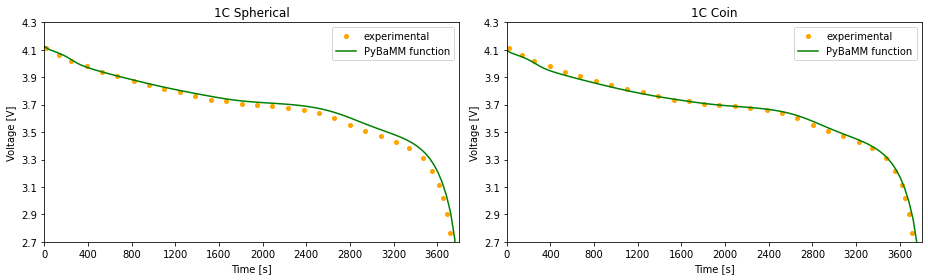

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_S0 = solutions_S0[0]["Time [s]"].entries
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], ".", color='orange', markersize=8, label='experimental')
ax1.plot(t_sol_S0, solutions_S0[0]["Terminal voltage [V]"](t_sol_S0), label="PyBaMM function", color="green")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Spherical")
ax1.set_xlim(0,3800)
ax1.set_ylim(2.7,4.2)
ax1.set_yticks(np.arange(2.7,4.4,0.2))
ax1.set_xticks(np.arange(0,4000,400))
ax1.legend(loc="best")

# plot the 1C Coin results
t_sol_C0 = solutions_C0[0]["Time [s]"].entries
ax2.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], ".", color='orange', markersize=8, label='experimental')
ax2.plot(t_sol_C0, solutions_C0[0]["Terminal voltage [V]"](t_sol_C0), label="PyBaMM function", color="green")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("1C Coin")
ax2.legend(loc="best")
ax2.set_xlim(0,3800)
ax2.set_ylim(2.7,4.2)
ax2.set_yticks(np.arange(2.7,4.4,0.2))
ax2.set_xticks(np.arange(0,4000,400))

plt.tight_layout()
#plt.savefig('1C original')
plt.show()

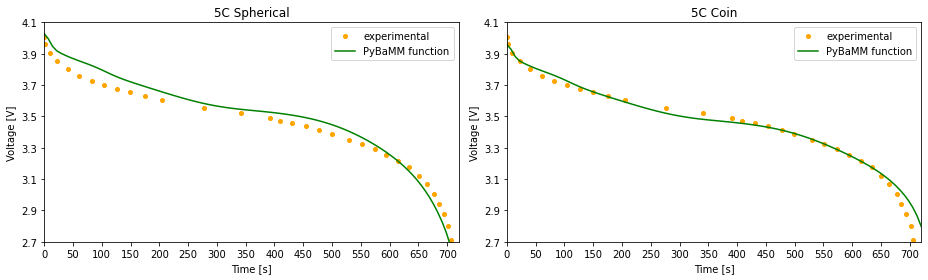

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_S0 = solutions_S0[1]["Time [s]"].entries
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax1.plot(t_sol_S0, solutions_S0[1]["Terminal voltage [V]"](t_sol_S0), label="PyBaMM function", color="green")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_C0 = solutions_C0[1]["Time [s]"].entries
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax2.plot(t_sol_C0, solutions_C0[1]["Terminal voltage [V]"](t_sol_C0), label="PyBaMM function", color="green")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.legend(loc="best")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))

plt.tight_layout()
#plt.savefig('original')
plt.show()

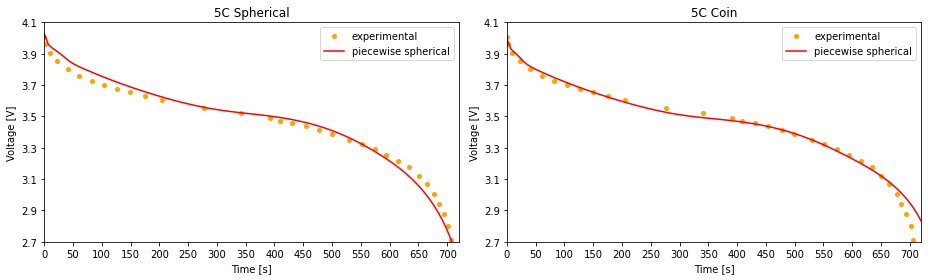

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_S1 = solutions_S1[1]["Time [s]"].entries
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax1.plot(t_sol_S1, solutions_S1[1]["Terminal voltage [V]"](t_sol_S1), label="piecewise spherical", color="red")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_C1 = solutions_C1[1]["Time [s]"].entries
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax2.plot(t_sol_C1, solutions_C1[1]["Terminal voltage [V]"](t_sol_C1), label="piecewise spherical", color="red")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('piecewise spherical')
plt.show()

2020-09-18 15:21:49,728 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


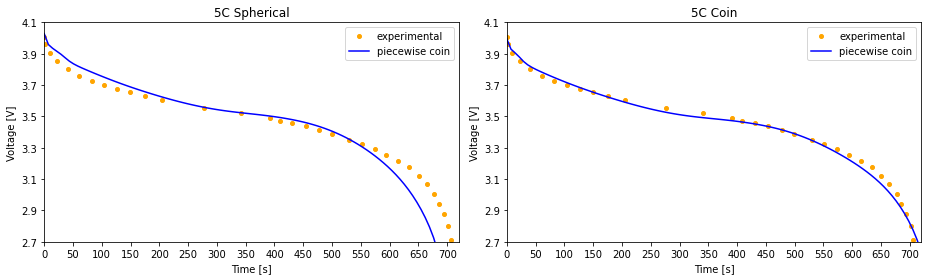

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_S2 = solutions_S2[1]["Time [s]"].entries
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax1.plot(t_sol_S2, solutions_S2[1]["Terminal voltage [V]"](t_sol_S2), label="piecewise coin", color="blue")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_C2 = solutions_C2[1]["Time [s]"].entries
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax2.plot(t_sol_C2, solutions_C2[1]["Terminal voltage [V]"](t_sol_C2), label="piecewise coin", color="blue")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('piecewise coin')
plt.show()

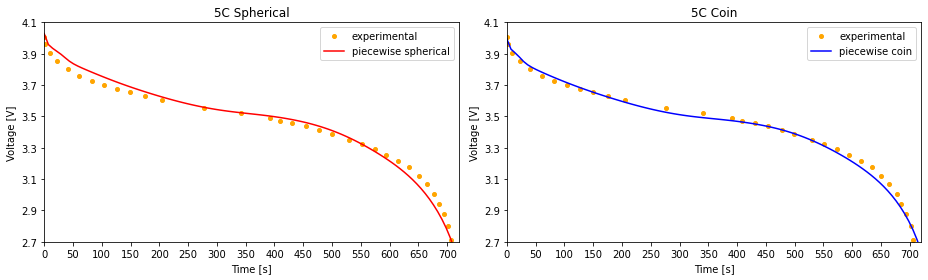

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_S1 = solutions_S1[1]["Time [s]"].entries
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax1.plot(t_sol_S1, solutions_S1[1]["Terminal voltage [V]"](t_sol_S1), label="piecewise spherical", color="red")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_C2 = solutions_C2[1]["Time [s]"].entries
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8, label='experimental')
ax2.plot(t_sol_C2, solutions_C2[1]["Terminal voltage [V]"](t_sol_C2), label="piecewise coin", color="blue")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('piecewise')
plt.show()